In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from ai_quantum.utils.matrix_compression import compress_matrix
from return_cov import f_return_cov
import networkx as nx

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
expected_value, cov_matrix = f_return_cov()

## Cov Matrix compression

In [3]:
edges = [(2,3), (3, 0), (0, 4), (4, 1), (1, 2)]

In [4]:
G = nx.Graph()
G.add_edges_from(edges)
lam, compress_cov_matrix = compress_matrix(cov_matrix, G)

## ----------

In [5]:
# Define the objective function to be optimized
q = 0.5 
B  = 2 
lamb= 0
depth = 10
qc_initial_state = dicke_statevector(len(expected_value), B)
qaoa = QAOA(expected_value, compress_cov_matrix, q, B, lamb, qc=qc_initial_state, 
                mixture_layer='ring_mixer', edges_hc=edges, edges_hb=edges)
qaoa.count_qpu_call = 0
def objective(params):
    gamma = params[:depth]
    beta = params[depth:]
    for i in range(depth):
        qaoa.add_layer(gamma[i], beta[i])

    energy = qaoa.measure_energy()
    qaoa.count_qpu_call += 1
    qaoa.restart()
    return energy

# Specify the initial parameters for optimization.
vec_gamma = []
vec_beta = []
initial_params = []
for _ in range(depth):
    gamma = np.random.uniform(0, 2*np.pi)
    beta = np.random.uniform(0, 2*np.pi)
    vec_gamma.append(gamma)
    vec_beta.append(beta)
    initial_params.append(gamma)
    initial_params.append(beta)

In [6]:
result = minimize(objective, initial_params, method='COBYLA')

gamma = result.x[:depth]
beta = result.x[depth:]

In [7]:
# Generate the optimal circuit.
qaoa.restart()
for i in range(depth):
    qaoa.add_layer(gamma[i], beta[i])
    
energy = qaoa.measure_energy()
count = qaoa.get_counts()
energy

-0.31418776042611385

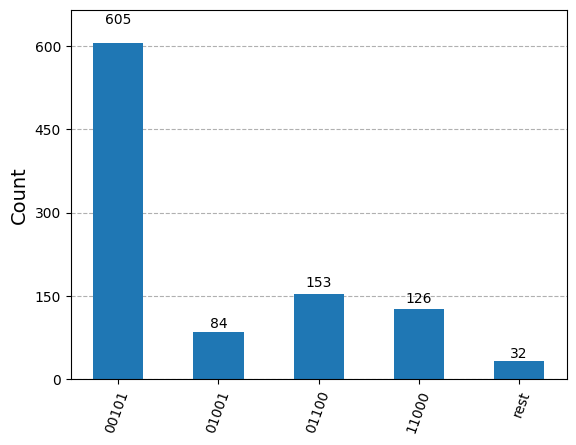

In [8]:
plot_histogram(count, number_to_keep=4)
plt.show()

In [9]:
qaoa.count_qpu_call

288